In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
algos = ['atofigh', 'felerius', 'gabow', 'lemon', 'matrix', 'pq', 'set', 'spaghetti', 'treap', 'yosupo']
repos = []
for data_set in ['fastestspeedrun', 'konect', 'networkrepository', 'yosupo', 'antilemon']:
    csv_name = f'results/runtime-{data_set}.csv'
    if not os.path.isfile(csv_name):
        print(data_set, 'missing')
        continue
    repo = pd.read_csv(csv_name, index_col=['file','algo'])
    repo['total'] = repo.con + repo.run + repo.rec + repo['del']
    # fill missing file/algo combinations with -1
    completeIndex = pd.MultiIndex.from_product((repo.index.levels[0],algos),names=repo.index.names)
    repo = repo.reindex(completeIndex, fill_value=-1)
    repo['source'] = data_set
    repos.append(repo)

data = pd.concat(repos)

In [3]:
timed_out = data[data.n==-1].reset_index()
print('timeouts w/o matrix')
print(timed_out[timed_out.algo!='matrix'][["file","algo"]])

timeouts w/o matrix
                                                file     algo
192                      networkrepository/big.wsoap    treap
194                 networkrepository/ch7-8-b5.wsoap  atofigh
195                 networkrepository/ch7-8-b5.wsoap    lemon
217                     networkrepository/pesa.wsoap    treap
218                  networkrepository/rbsa480.wsoap    treap
220                  networkrepository/rbsb480.wsoap    treap
221              networkrepository/shar_te2-b3.wsoap  atofigh
222              networkrepository/shar_te2-b3.wsoap    lemon
227  networkrepository/soc-sign-Slashdot081106.wsoap    treap
229  networkrepository/soc-sign-Slashdot090216.wsoap    treap
231  networkrepository/soc-sign-Slashdot090221.wsoap    treap
233        networkrepository/soc-sign-epinions.wsoap    treap
246                       antilemon/anti100000.wsoap  atofigh
248                      antilemon/anti1000000.wsoap  atofigh
249                      antilemon/anti1000000.wso

In [4]:
algos = data.index.levels[1].tolist()
colors = {}
marker = {}
for i,alg in enumerate(algos):
    colors[alg] = plt.get_cmap("tab10")(i) 
    marker[alg] = '*+.2<>DPX^psv'[i]

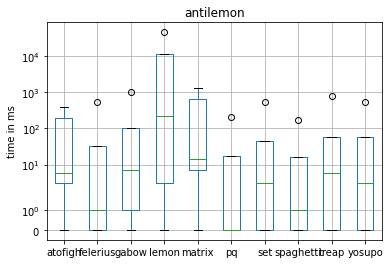

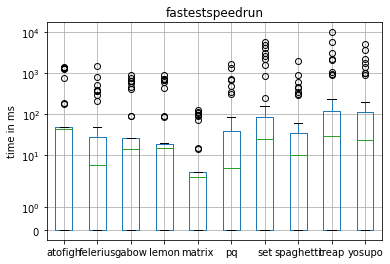

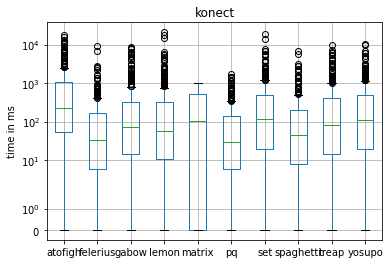

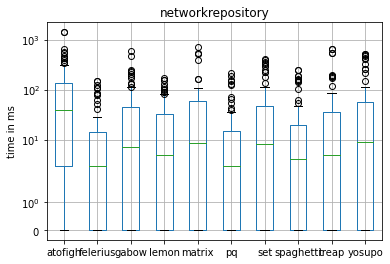

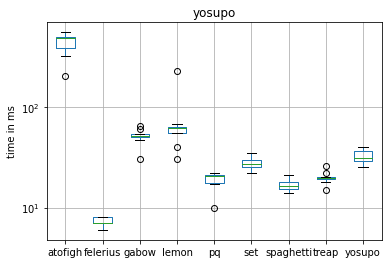

In [8]:
for source, view in data.groupby('source'):
    view[view.n!=-1].unstack(level=1).total.plot.box()
    plt.yscale('symlog')
    plt.grid()
    plt.autoscale()
    plt.ylabel('time in ms')
    plt.title(source)
    plt.show()

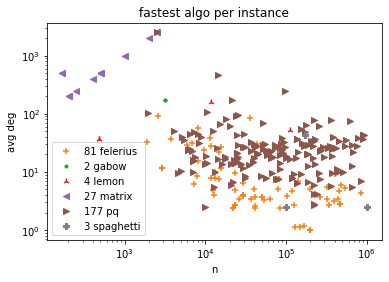

In [39]:
# w/o ties (all not timeout and untied best)
relevant = data[data.n!=-1].groupby('file').filter(lambda grp: (grp.total==grp.total.min()).sum()==1)
fastest = relevant.loc[relevant.groupby('file').total.idxmin()]

fastest['avg deg'] = fastest.m / fastest.n
for algo, grp in fastest.reset_index(level=1).groupby('algo'):
    plt.gca().scatter(grp['n'], grp['avg deg'], label=f'{len(grp)} {algo}', color=colors[algo], marker=marker[algo])

plt.loglog()
plt.legend()
plt.xlabel('n')
plt.ylabel('avg deg')
plt.title('fastest algo per instance')
plt.savefig('temp_plots/fastest.pdf')

Text(0, 0.5, 'time in ms')

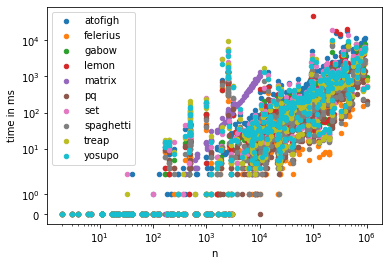

In [74]:
for algo, view in data.groupby('algo'):
    view.plot.scatter('n', 'total', ax=plt.gca(), label=algo, color=colors[algo])
plt.yscale('symlog')
plt.semilogx()
plt.ylabel('time in ms')

total        1342
timeout    120000
dtype: int64
total      872
timeout      0
dtype: int64
total         20882
timeout    11340000
dtype: int64
total         3197
timeout    2100000
dtype: int64
total           0
timeout    600000
dtype: int64


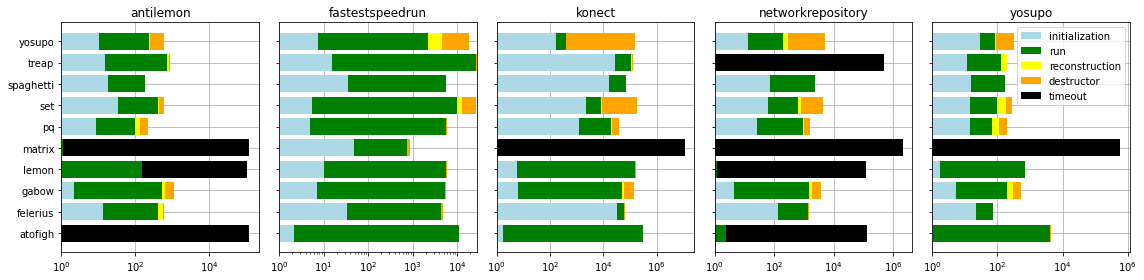

In [38]:
to_plot = [
    ('con', 'initialization','lightblue'), 
    ('run', 'run', 'green'), 
    ('rec','reconstruction', 'yellow'), 
    ('del','destructor', 'orange'),
    ('timeout','timeout', 'black')
]

grps = data.groupby('source')

fig, axs = plt.subplots(ncols=len(grps), sharey=True, figsize=(16,4))
for (source, view), ax in zip(grps,axs):
    view = view.copy()
    view['timeout'] = 0
 
    for col in ['run', 'con','rec','del', 'total']:
        view[col].replace(-1,0,inplace=True)
    view.loc[view.n==-1,'timeout'] = 60*1000
    
    print(view.xs('matrix', level=1, drop_level=False)[['total','timeout']].sum())

    timings = view.sum(level=1).reset_index()
    timings['total'] += timings['timeout']
    for col in ['run', 'con','rec','del', 'timeout']:
        timings[col] = timings['total'] ** (timings[col] / timings['total'])
    
    timings['offset'] = 1 # log of this is 0
    for column,label,color in to_plot:
        ax.barh(y=timings['algo'], width=timings.offset * timings[column] - timings.offset, label=label, color=color, left=timings.offset)
        timings['offset'] *= timings[column] # multiplying logs is same as adding in non-log
        
    ax.set_title(source)
    ax.semilogx()
    ax.set_xlim(left=1)
    ax.grid()
    ax.set_axisbelow(True)

axs[-1].legend()
fig.tight_layout()
plt.savefig('temp_plots/time_bar.pdf')